<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#step1-加载数据" data-toc-modified-id="step1-加载数据-1">step1 加载数据</a></span></li><li><span><a href="#step2-可视化" data-toc-modified-id="step2-可视化-2">step2 可视化</a></span></li><li><span><a href="#step3-特征提取" data-toc-modified-id="step3-特征提取-3">step3 特征提取</a></span></li><li><span><a href="#step4-回归分析" data-toc-modified-id="step4-回归分析-4">step4 回归分析</a></span></li><li><span><a href="#step5-比较结果" data-toc-modified-id="step5-比较结果-5">step5 比较结果</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import jieba
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge

#from collections import defaultdict
#from sklearn.feature_extraction.text import TfidfVectorizer

#from sklearn.linear_model import LinearRegression
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBRegressor
#from sklearn.neighbors import KNeighborsRegressor
#from sklearn.model_selection import GridSearchCV

#from sklearn.neighbors import KNeighborsRegressor
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import mean_absolute_error

#from sklearn.metrics import mean_absolute_error,mean_squared_error
#from sklearn.model_selection import train_test_split
#import time

## step1 加载数据

In [2]:
data = pd.read_excel('./jobs_4k.xls')
print(data.head())

   id         positionName district stationname jobNature  \
0   3               财务产品经理      海淀区          上地        全职   
1   4                 产品专家      海淀区         中关村        全职   
2   5                 产品总监      海淀区         中关村        全职   
3   6  联盟广告产品运营专家/专员-【商业化】      海淀区          东单        全职   
4   7                 产品总监      海淀区         中关村        全职   

                   companyLabelList industryField   salary companySize  \
0  ['节日礼物', '年底双薪', '定期体检', '七险一金']    物流丨运输,软件开发  10k-15k   500-2000人   
1  ['五险一金', '弹性工作', '带薪年假', '免费两餐']          企业服务  30k-50k   500-2000人   
2  ['五险一金', '弹性工作', '带薪年假', '免费两餐']          企业服务  40k-75k   500-2000人   
3  ['股票期权', '弹性工作', '定期体检', '岗位晋升']         文娱丨内容  20k-40k     2000人以上   
4  ['领导好', '五险一金', '领军企业', '脑力密集型']      移动互联网,社交  20k-38k      15-50人   

                      skillLables           createTime companyFullName  \
0           ['产品设计', '后台', 'B2B']  2020-05-15 15:10:02  北京福佑多多信息技术有限公司   
1                              []  2020-

## step2 可视化

In [3]:
# positionName和skillLables探索
positionName = list(data['positionName'])
skillLables = list(data['skillLables'])
print(positionName) # ->['财务产品经理', '产品专家'……
print('\n\n')
print(skillLables) # ->["['Python']"……]

['财务产品经理', '产品专家', '产品总监', '联盟广告产品运营专家/专员-【商业化】', '产品总监', '产品总监', '产品总监', '产品总监', '资深产品经理（产品专家）', '智能交通信息安全高级产品经理/产品总监/行业专家', '产品总监', '产品总监', '高级产品经理', '产品经理/总监（视觉芯片半导体', '产品经理', '产品经理', '产品经理（客户端产品策划）（北京）', '产品经理（客户端产品策划）', '高级产品经理', '产品经理', '产品经理', '产品经理', '产品经理', '后台产品经理', '高级产品经理', '产品总监', '产品总监/高级产品经理(J10515)', '高级客服产品经理/专家', '高级产品经理/总监（云计算）', '产品总监', '高级产品经理/总监（云计算）', '产品总监', '商业化高级产品经理/产品专家（CRM）', '高级产品经理', '产品策划专员', '产品总监', '产品经理', '高级产品经理/总监', '产品总监', 'ToB商业化大数据产品经理 — 数据分析专家', '高级产品经理', '产品专员', '高级产品经理', '高德-高级产品经理/专家-共享', '高级产品经理/专家', '产品专员', '高级产品经理', '产品专员', '产品总监', '产品经理/总监', '高级产品经理', '高级产品经理', '产品经理', '产品经理', '产品经理', '产品总监', '产品经理', '产品总监', '产品总监', '产品总监', '后台产品经理', '产品总监', '产品专家', '高级产品经理', '高级产品经理/产品专家', '产品专员', '产品总监', '产品总监', '产品总监', '产品总监', '产品总监', '产品经理课程高级教学专家', '产品总监', '产品总监', '产品总监', '产品总监（用户端）', '产品专家（系统端）', '产品总监', '产品运营专员（直播）', '产品经理', 'PM/产品总监', '产品总监', '产品总监', '高级产品经理', '产品总监', '产品经理/专家（人工智能）', '产品总监', '产品经理', '用户增长产品专家', '产品专家', '产品总监', '产品经理', '高级车联网产品经理 

In [4]:
# 构造一一对应的字典
from collections import defaultdict
position_skill_graph = defaultdict(list)
for p,s in zip(positionName,skillLables):
    position_skill_graph[p] += eval(s)
print(position_skill_graph) #->defaultdict(<class 'list'>, {'财务产品经理': ['产品设计', '后台', 'B2B']……）

defaultdict(<class 'list'>, {'财务产品经理': ['产品设计', '后台', 'B2B'], '产品专家': ['产品设计', '产品策划', '业务流程管理', '战略管理', '领导力', 'OKR管理', '产品设计'], '产品总监': ['电商', '社交电商', '产品策划', '需求分析', '用户研究', '交互设计', '商业产品', '移动产品/APP', '在线教育产品', '产品设计', '用户研究', '教育', '目标管理', 'OKR管理', '领导力', '团队建设', '企业软件', '数据', 'ERP', '功能产品', '部门管理', '业务流程管理', '团队建设', 'OKR管理', '产品设计', '教育', '社交/SNS', '数据分析', '产品设计', '教育', '社交/SNS', '数据分析', '创业', '部门管理', '领导力', '团队建设', '部门管理', '产品设计', '产品设计', '产品策划', '需求分析', '项目管理', '产品设计', '移动产品/APP', '产品设计', '移动产品/APP', '产品设计', '产品策划', '移动产品/APP', '产品设计', '需求分析', '项目管理', '后台产品', 'B2C', '用户研究', '产品设计', '项目管理', '需求分析', '产品策划', '产品设计', '产品设计', '产品设计', '项目管理', '移动产品/APP', '数据分析', '用户增长', '产品设计', '产品设计', '电商', '产品设计', '产品设计', '产品策划', '用户研究', '需求分析', '交互设计', '产品策划', '产品设计', '金融', '产品设计', '金融', '产品策划', '用户研究', '需求分析', '项目管理', '金融', '产品设计', '策略', '企业软件', 'B端产品', '产品设计', '需求分析', '商业产品', '产品设计', '产品策划', '结构设计', '交互设计', '商业产品', '需求分析', '移动产品/APP', '产品设计', '产品策划', '企业软件', '需求分析', '产品设计', '产品策划', '人工智能', '智能硬件

['初/中级QA测试工程师', '运维经理', '少儿编程讲师（web/python/java）', 'python专家(J12716)', '运维开发工程师（DevOps）', 'python开发', '大数据运维工程师', '数据产品经理 - 【智能分析】', '运维工程师', 'ui设计师']
['ui设计师', '运维工程师', '运维经理', '大数据运维工程师', 'python开发', '初/中级QA测试工程师', '运维开发工程师（DevOps）', 'Python', 'Docker', 'MongoDB', 'Linux', 'Shell']


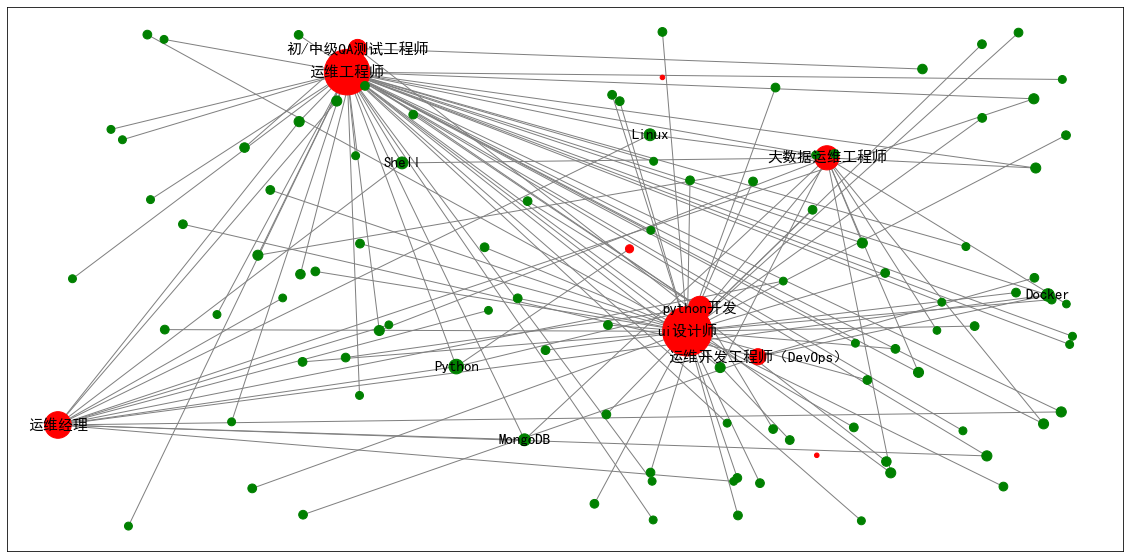

In [5]:
import networkx as nx
import random
# 随机选择职位
topk = 10
position_skill_sample_graph = defaultdict(list)
sample_position = random.sample(positionName,k=topk)
print(sample_position)
for p in sample_position:
    position_skill_sample_graph[p] = position_skill_graph[p]
# 设置中文字体为黑体
plt.rcParams['font.sans-serif'] = ['SimHei']
# 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False
# 设置画布大小
plt.figure(figsize=(20,10))
# 构造G
G = nx.Graph(position_skill_sample_graph)
# 计算node的pr值
pr = nx.pagerank(G)
# 构造layout
pos = nx.random_layout(G)
# 根据pr值来设置部分标签可见
topk = topk+2
labels = defaultdict(str)
sort_pr = sorted(pr.items(),key=lambda x:x[1],reverse=True)
pp = [p[0] for p in sort_pr[:topk]]
print(pp)
for p in pp:
    labels[p] = p
labels = dict(labels)
# 根据pr值来设置node的大小
de2 = [v*15000 for k,v in dict(pr).items()]
# 根据类型来设置node的颜色
color = ['red' if node in sample_position else 'green' for node in G.nodes]
# 画图
nx.draw_networkx_labels(G,pos,labels, font_size=15,font_color='black')
nx.draw_networkx(G, pos, node_size=de2, with_labels = False,node_color=color, linewidths=None, width=1.0, edge_color ='gray')
plt.show()

## step3 特征提取

In [6]:
# 特征X，去掉salary
content = data.copy()
X_content = content.drop(['salary'], axis=1)

target = content['salary'].tolist()
X_content['merged'] = X_content.apply(lambda x: ''.join(str(x)), axis=1)
# print(X_content['merged'])

# 转换为list
X_string = X_content['merged'].tolist()

def get_one_row_job_string(x_string_row):
    job_string = ''
    for i, element in enumerate(x_string_row.split('\n')):
        if len(element.split()) == 2:
            _, value = element.split()
            #
            if i == 0:
                continue
            job_string += value
    return job_string


cutted_X = []

def token(string):
    return re.findall('\w+', string)


for i, row in enumerate(X_string):
    job_string = get_one_row_job_string(row)
    cutted_X.append(' '.join(list(jieba.cut(''.join(token(job_string))))))

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(cutted_X)

# 求平均值 10k-15k => 12.5k
# map把数值映射到float，然后转为list给np.mean进行运算
target_numerical = [np.mean(list(map(float, re.findall('\d+', s)))) for s in target]
Y = target_numerical

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\JIALIZ~1\AppData\Local\Temp\jieba.cache
Loading model cost 1.651 seconds.
Prefix dict has been built successfully.


## step4 回归分析

In [7]:
# 使用KNN模型
model_knn = KNeighborsRegressor(n_neighbors=4)
# 初始化平均回归的KNN回归器
# model = KNeighborsRegressor(n_neighbors=2, weights='uniform')
# #初始化距离加权回归的KNN回归器
# model = KNeighborsRegressor(n_neighbors=2, weights='distance')
model_knn.fit(X, Y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                    weights='uniform')

In [8]:
# 使用朴素贝叶斯
model = BayesianRidge(compute_score=True)
model.fit(X.toarray(), Y)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=True, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

## step5 比较结果

In [10]:
def predict_by_label(test, model):
    test_words = list(jieba.cut(test))
    test_vec = vectorizer.transform(test_words)
    predict_value = model.predict(test_vec)
    return predict_value[0]

In [11]:
test1 = '测试 北京 3年 专科'
print(test1, predict_by_label(test1, model))
print(test1, predict_by_label(test1, model_knn))
test2 = '测试 北京 4年 专科'
print(test2, predict_by_label(test2, model))
print(test2, predict_by_label(test2, model_knn))
test3 = '算法 北京 4年 本科'
print(test3, predict_by_label(test3, model))
print(test3, predict_by_label(test3, model_knn))
test4 = 'UI 北京 4年 本科'
print(test4, predict_by_label(test4, model))
print(test4, predict_by_label(test4, model_knn))
test5 = "广州Java本科3年掌握大数据"
print(test5, predict_by_label(test5, model))
print(test5, predict_by_label(test5, model_knn))
test6 = "沈阳Java硕士3年掌握大数据"
print(test6, predict_by_label(test6, model))
print(test6, predict_by_label(test6, model_knn))
test7 = "沈阳Java本科3年掌握大数据"
print(test7, predict_by_label(test7, model))
print(test7, predict_by_label(test7, model_knn))
test8 = "北京算法硕士3年掌握图像识别"
print(test8, predict_by_label(test8, model))
print(test8, predict_by_label(test8, model_knn))

测试 北京 3年 专科 14.243709878815368
测试 北京 3年 专科 15.125
测试 北京 4年 专科 14.243709878815368
测试 北京 4年 专科 15.125
算法 北京 4年 本科 20.945886022614793
算法 北京 4年 本科 23.75
UI 北京 4年 本科 15.555066779412506
UI 北京 4年 本科 17.5
广州Java本科3年掌握大数据 25.84443414454298
广州Java本科3年掌握大数据 20.625
沈阳Java硕士3年掌握大数据 21.51800464187414
沈阳Java硕士3年掌握大数据 27.5
沈阳Java本科3年掌握大数据 21.51800464187414
沈阳Java本科3年掌握大数据 27.5
北京算法硕士3年掌握图像识别 32.09369731860339
北京算法硕士3年掌握图像识别 20.75
